In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
import xgboost as xgb
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score, precision_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from time import time

In [2]:
train_url = 'data/train_data.csv'
test_url = 'data/test_data.csv'

train_split = pd.read_csv(train_url)
test_split = pd.read_csv(test_url)

In [3]:
train_split.head()

,index,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,...,wind-vwnd-925-2010-11,wind-vwnd-925-2010-12,wind-vwnd-925-2010-13,wind-vwnd-925-2010-14,wind-vwnd-925-2010-15,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20
0,0,0.0,0.833333,9/1/14,237.00,29.02,31.64,29.57,30.73,29.71,...,-27.68,-37.21,8.32,9.56,-2.03,48.13,28.09,-13.50,11.90,4.58
1,1,0.0,0.833333,9/2/14,228.90,29.02,31.64,29.57,30.73,29.71,...,-21.13,-36.57,8.77,21.17,4.44,48.60,27.41,-23.77,15.44,3.42
2,2,0.0,0.833333,9/3/14,220.69,29.02,31.64,29.57,30.73,29.71,...,-10.72,-34.16,6.99,32.16,5.01,48.53,19.21,-33.16,15.11,4.82
3,3,0.0,0.833333,9/4/14,225.28,29.02,31.64,29.57,30.73,29.71,...,0.33,-31.04,6.17,39.66,-1.41,50.59,8.29,-37.22,18.24,9.74
4,4,0.0,0.833333,9/5/14,237.24,29.02,31.64,29.57,30.73,29.71,...,9.83,-31.80,7.47,38.62,-5.21,54.73,-2.58,-42.30,21.91,10.95


In [4]:
test_split.head()

,index,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,...,wind-vwnd-925-2010-11,wind-vwnd-925-2010-12,wind-vwnd-925-2010-13,wind-vwnd-925-2010-14,wind-vwnd-925-2010-15,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20
0,375734,0.0,0.833333,11/1/22,339.88,30.88,30.92,29.17,31.02,29.47,...,-19.28,-39.77,-29.25,40.88,-8.31,14.91,-24.62,31.05,-23.69,6.27
1,375735,0.0,0.833333,11/2/22,334.63,30.88,30.92,29.17,31.02,29.47,...,-19.58,-43.14,-28.62,45.37,-5.42,16.97,-23.94,28.84,-20.61,14.16
2,375736,0.0,0.833333,11/3/22,337.83,30.88,30.92,29.17,31.02,29.47,...,-13.73,-44.22,-27.67,49.76,-1.31,21.44,-19.06,26.85,-16.78,13.42
3,375737,0.0,0.833333,11/4/22,345.81,30.88,30.92,29.17,31.02,29.47,...,-7.97,-49.47,-19.32,52.62,-0.44,21.65,-23.12,23.70,-18.62,10.69
4,375738,0.0,0.833333,11/5/22,357.39,30.88,30.92,29.17,31.02,29.47,...,-0.80,-56.07,-9.89,51.23,-7.57,19.86,-30.56,20.66,-25.08,19.64


In [5]:
x_train = train_split.drop(['contest-tmp2m-14d__tmp2m'], axis=1)
y_train = train_split['contest-tmp2m-14d__tmp2m']
x_test = test_split.copy()
# x_test = test_split.drop(['startdate'], axis=1).reset_index(drop=True)

# EDA

In [6]:
y_train.describe()

count    375734.000000
mean         11.858568
std           9.867901
min         -20.358963
25%           4.818231
50%          12.285770
75%          19.441170
max          37.238782
Name: contest-tmp2m-14d__tmp2m, dtype: float64

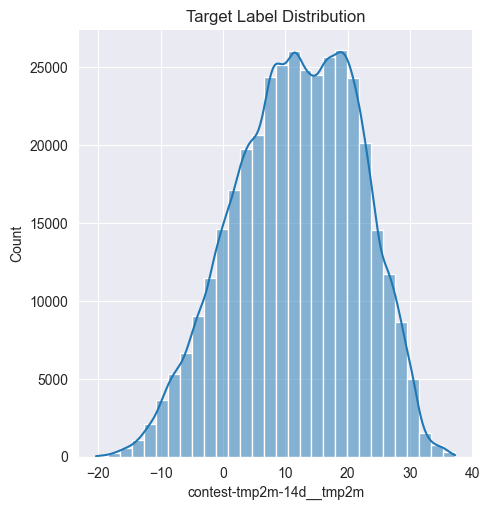

In [7]:
sns.displot(data=y_train, bins=30, kind='hist', kde=True,).set(title='Target Label Distribution')
plt.show()

In [8]:
x_train.describe()

,index,lat,lon,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,nmme0-tmp2m-34w__gfdlflora0,...,wind-vwnd-925-2010-11,wind-vwnd-925-2010-12,wind-vwnd-925-2010-13,wind-vwnd-925-2010-14,wind-vwnd-925-2010-15,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20
count,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,359800.000000,375734.000000,375734.000000,375734.000000,...,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000
mean,187866.500000,0.592766,0.517964,276.744064,10.801682,12.726739,10.099323,11.638229,10.733886,11.772646,...,-1.209959,-8.109918,6.800684,19.251970,-17.697565,-9.846867,-6.231860,16.014364,10.489945,11.296334
std,108465.207359,0.251744,0.272059,198.085182,10.952417,11.073553,10.339626,10.574276,9.403434,10.689967,...,37.317333,36.201507,38.458878,25.288526,31.946748,34.164678,27.050356,25.847455,25.070435,25.113214
min,0.000000,0.000000,0.000000,-2.310000,-14.960000,-14.970000,-11.720000,-17.560000,-13.720000,-13.330000,...,-94.570000,-89.940000,-64.870000,-39.280000,-100.560000,-106.080000,-93.980000,-52.610000,-66.110000,-57.610000
25%,93933.250000,0.409091,0.300000,104.062500,1.550000,3.650000,1.640000,3.080000,3.390000,2.970000,...,-27.200000,-33.350000,-19.650000,1.960000,-40.030000,-32.170000,-20.170000,-0.360000,-6.790000,-5.570000
50%,187866.500000,0.590909,0.533333,250.320000,9.950000,11.890000,9.490000,11.600000,10.890000,11.280000,...,-3.200000,-9.390000,2.330000,20.050000,-16.710000,-8.560000,-6.030000,18.650000,11.860000,11.650000
75%,281799.750000,0.818182,0.766667,420.010000,20.230000,22.110000,18.740000,20.360000,18.330000,20.300000,...,24.940000,17.960000,28.660000,35.090000,4.390000,10.500000,11.630000,31.210000,29.040000,29.180000
max,375733.000000,1.000000,1.000000,1185.140000,36.080000,36.030000,33.390000,34.640000,35.750000,38.350000,...,113.920000,96.550000,106.420000,91.760000,56.550000,83.890000,64.850000,90.390000,76.890000,88.660000


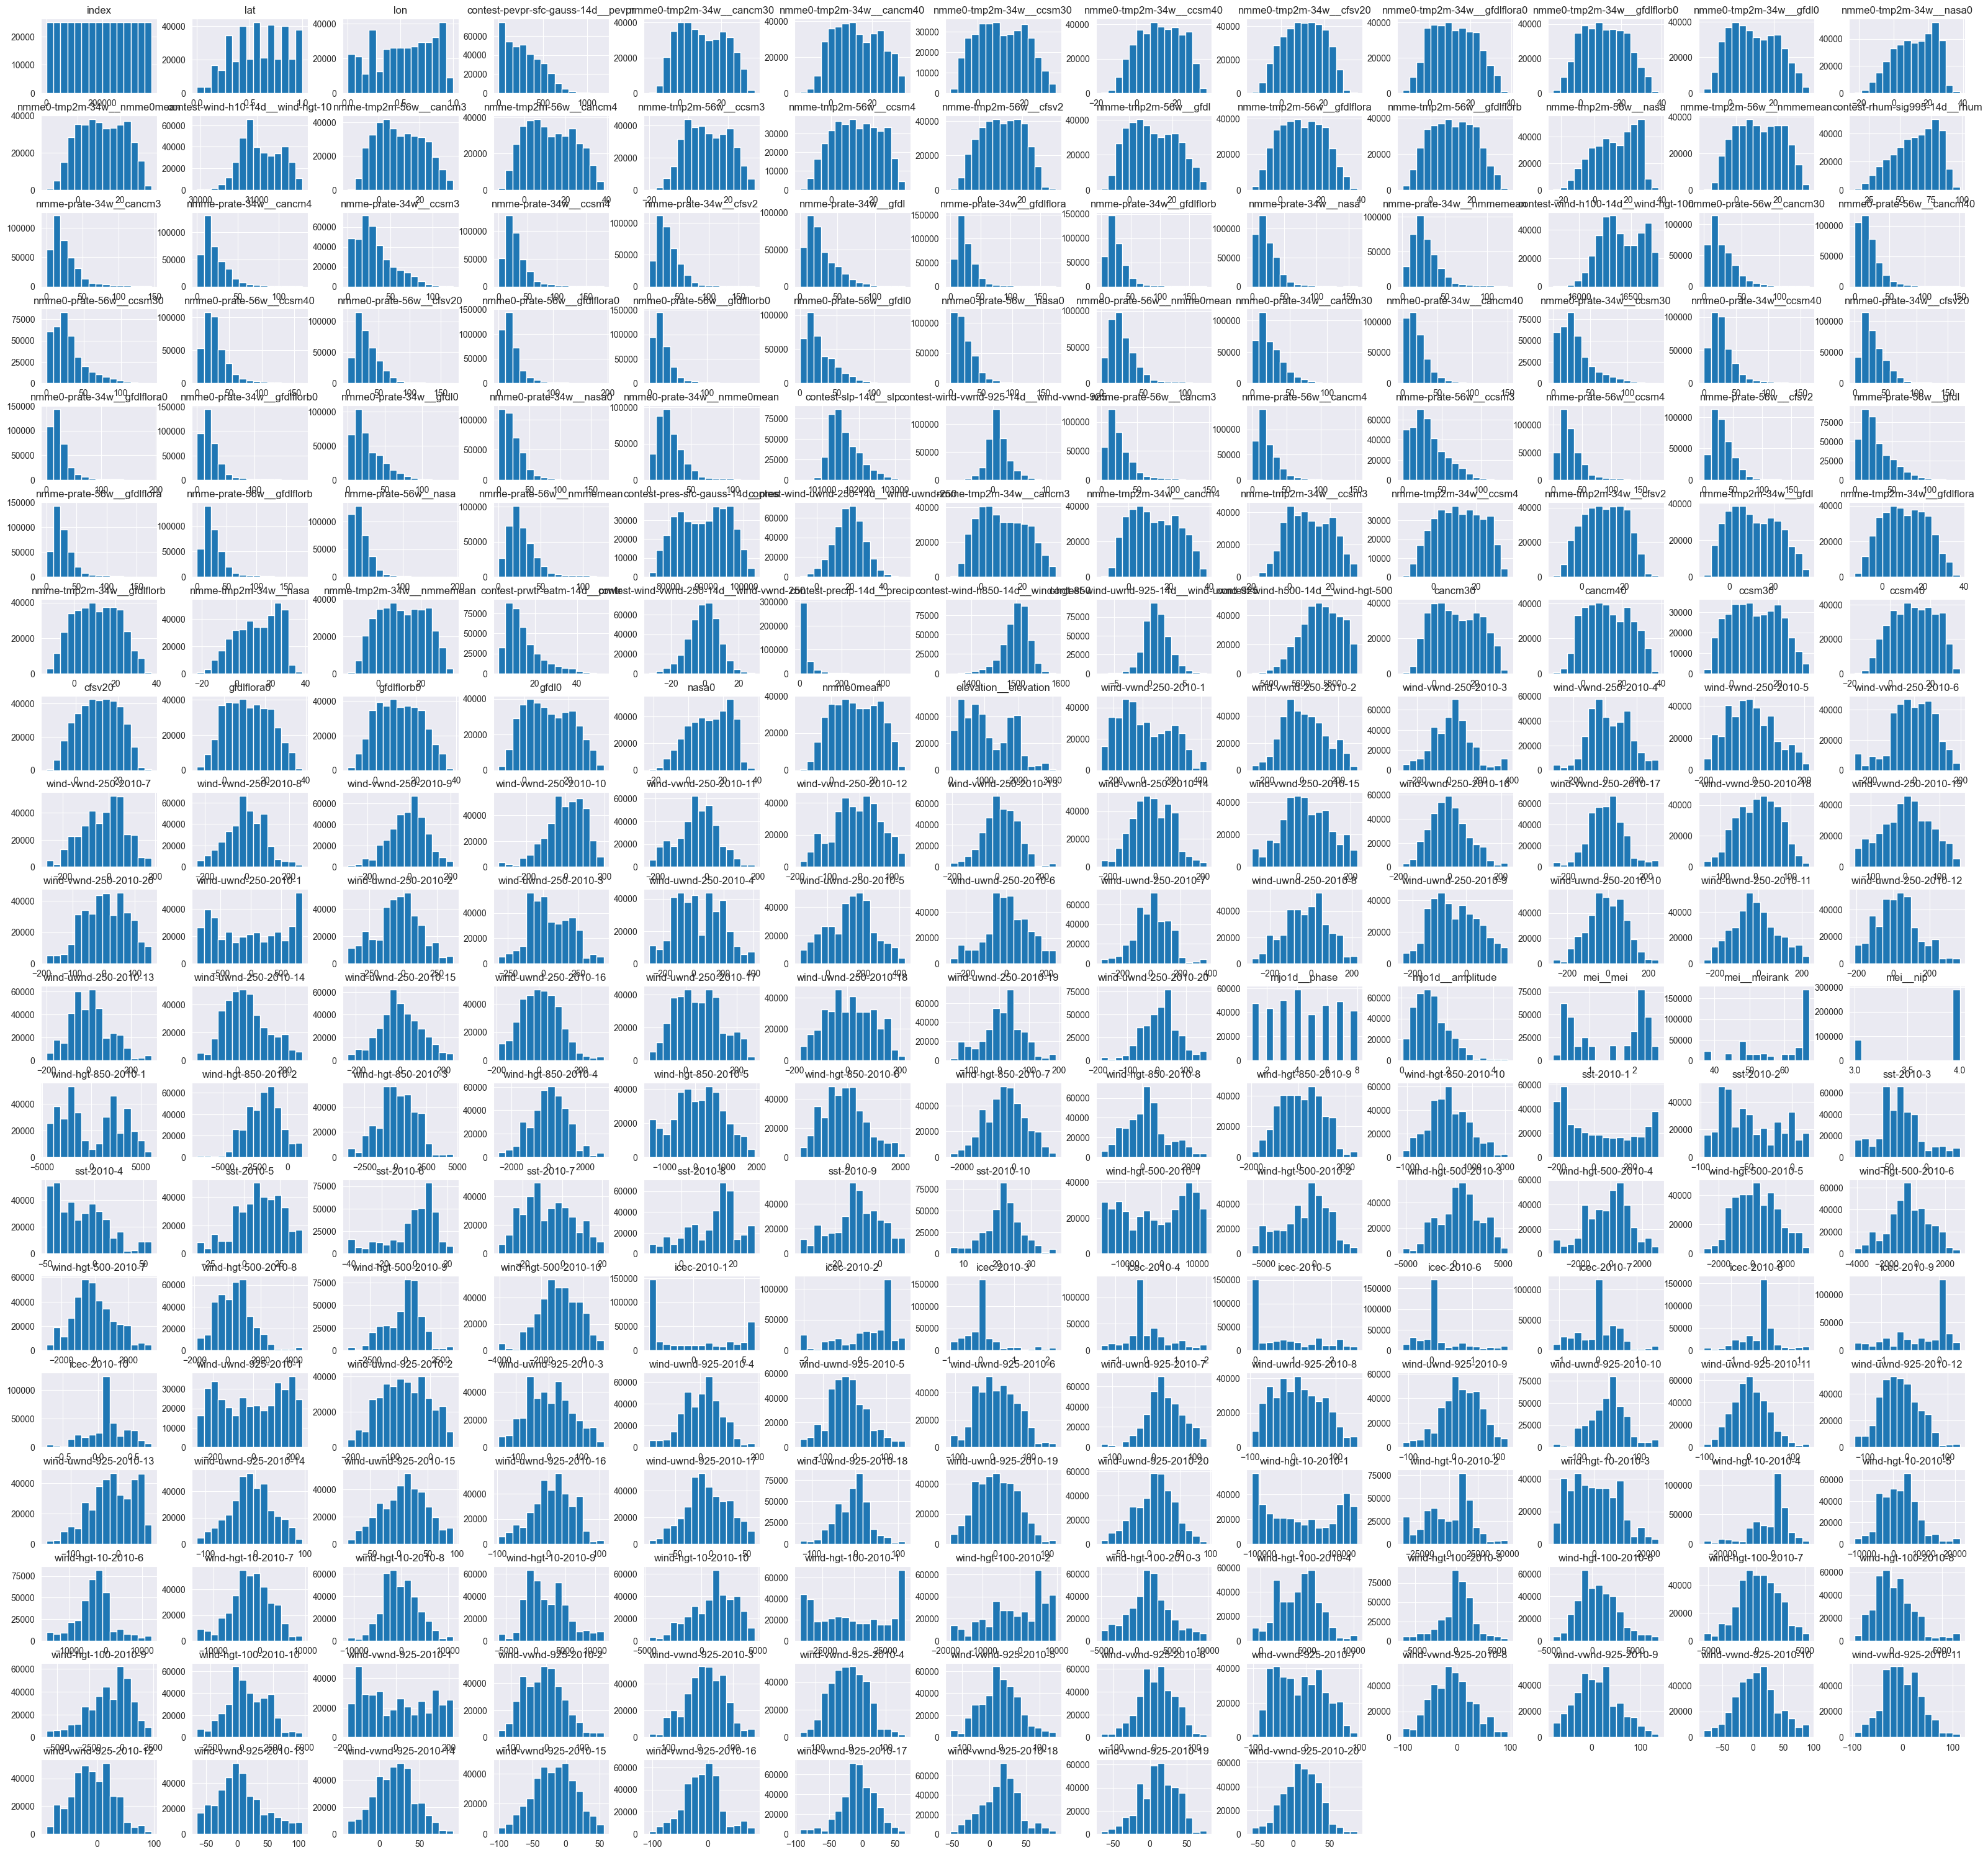

In [9]:
# This might take a couple of minutes to run - we are generating over 80 plots here!
x_train.hist(bins=15,figsize=(40, 40), layout=(20, 13))
plt.show()

# Pre-processing

## Fill nulls

In [10]:
tmp = pd.DataFrame(train_split.isna().sum()) \
        .rename(columns={0: 'cnt'})

null_ls = tmp[tmp.cnt != 0].reset_index()
null_ls

,index,cnt
0,nmme0-tmp2m-34w__ccsm30,15934
1,nmme-tmp2m-56w__ccsm3,10280
2,nmme-prate-34w__ccsm3,8738
3,nmme0-prate-56w__ccsm30,15934
4,nmme0-prate-34w__ccsm30,15934
5,nmme-prate-56w__ccsm3,10280
6,nmme-tmp2m-34w__ccsm3,8738
7,ccsm30,15934


In [11]:
mean_values = {}
for i in null_ls['index']:
    mean = x_train.loc[:, i].mean()
    mean_values[i] = mean

mean_values

{'nmme0-tmp2m-34w__ccsm30': 10.099322984991662,
 'nmme-tmp2m-56w__ccsm3': 9.663224126702678,
 'nmme-prate-34w__ccsm3': 31.26154696508954,
 'nmme0-prate-56w__ccsm30': 29.62399274596999,
 'nmme0-prate-34w__ccsm30': 29.65260622568093,
 'nmme-prate-56w__ccsm3': 32.00762760839941,
 'nmme-tmp2m-34w__ccsm3': 9.820987313213221,
 'ccsm30': 10.101533351862145}

In [12]:
for k, v in mean_values.items():
    x_train[k].fillna(value=v, inplace=True)

## Label encoder

In [13]:
le = LabelEncoder()

le.fit(x_train['climateregions__climateregion'])

x_train['climateregions__climateregion'] = le.fit_transform(x_train['climateregions__climateregion'])
x_test['climateregions__climateregion'] = le.fit_transform(x_test['climateregions__climateregion'])

In [14]:
x_train.head()

,index,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,...,wind-vwnd-925-2010-11,wind-vwnd-925-2010-12,wind-vwnd-925-2010-13,wind-vwnd-925-2010-14,wind-vwnd-925-2010-15,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20
0,0,0.0,0.833333,9/1/14,237.00,29.02,31.64,29.57,30.73,29.71,...,-27.68,-37.21,8.32,9.56,-2.03,48.13,28.09,-13.50,11.90,4.58
1,1,0.0,0.833333,9/2/14,228.90,29.02,31.64,29.57,30.73,29.71,...,-21.13,-36.57,8.77,21.17,4.44,48.60,27.41,-23.77,15.44,3.42
2,2,0.0,0.833333,9/3/14,220.69,29.02,31.64,29.57,30.73,29.71,...,-10.72,-34.16,6.99,32.16,5.01,48.53,19.21,-33.16,15.11,4.82
3,3,0.0,0.833333,9/4/14,225.28,29.02,31.64,29.57,30.73,29.71,...,0.33,-31.04,6.17,39.66,-1.41,50.59,8.29,-37.22,18.24,9.74
4,4,0.0,0.833333,9/5/14,237.24,29.02,31.64,29.57,30.73,29.71,...,9.83,-31.80,7.47,38.62,-5.21,54.73,-2.58,-42.30,21.91,10.95


## Create new columns

In [15]:
x_train['year'] = pd.DatetimeIndex(x_train['startdate']).year
x_train['month'] = pd.DatetimeIndex(x_train['startdate']).month
x_train['day'] = pd.DatetimeIndex(x_train['startdate']).day
x_test['year'] = pd.DatetimeIndex(x_test['startdate']).year
x_test['month']=pd.DatetimeIndex(x_test['startdate']).month
x_test['day']=pd.DatetimeIndex(x_test['startdate']).day

In [16]:
x_train.drop(columns='startdate', inplace=True)

In [17]:
x_test.drop(columns='startdate', inplace=True)

# Model

## LGBMRegressor

In [19]:
import optuna

In [20]:
scaler = StandardScaler()

scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [27]:
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.2)

In [31]:
start = time()

lgbm = LGBMRegressor(
    n_estimators=5000,
    n_jobs=-1,
    max_depth=30
)

lgbm.fit(X_train, Y_train)

print(f'Done in {time() - start} s')

Done in 151.82937002182007 s


In [32]:
Y_train_pred = lgbm.predict(X_train)
Y_test_pred = lgbm.predict(X_val)

rmse_train = mean_squared_error(Y_train, Y_train_pred, squared=False)
rmse_test = mean_squared_error(Y_val, Y_test_pred, squared=False)

print(f'RMSE train {rmse_train}')
print(f'RMSE test {rmse_test}')

RMSE train 0.16155638408327602
RMSE test 0.23962111778255868


In [34]:
submit = lgbm.predict(x_test)
submit

array([27.27090462, 27.23739801, 27.28731934, ...,  2.63403517,
        2.31490115,  2.189869  ])

In [38]:
index = test_split['index']

submit_df = pd.DataFrame({'contest-tmp2m-14d__tmp2m': pd.Series(submit), 'index': index})
submit_df.head()

,contest-tmp2m-14d__tmp2m,index
0,27.270905,375734
1,27.237398,375735
2,27.287319,375736
3,27.565180,375737
4,27.417594,375738


In [40]:
submit_df.to_csv('submit_lgbm.csv', index=False)

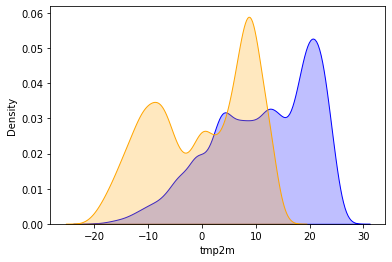

In [ ]:
# fig, ax = plt.subplots()
# sns.kdeplot(data=y_train,  color='blue', fill=True, ax=ax)
# sns.kdeplot(data=y_test, color='orange', fill=True, ax=ax)
# plt.show()

From the plot above, it's clear that our label distribution has shifted from the training data to the test data.

Let's compare the training and test distributions of a few of our features.  The function below plots the distributions of a list of 8 features.  Feel free to add to the list to explore more features.  The **training data** is shown in **blue** and the **test data** is shown in **orange**

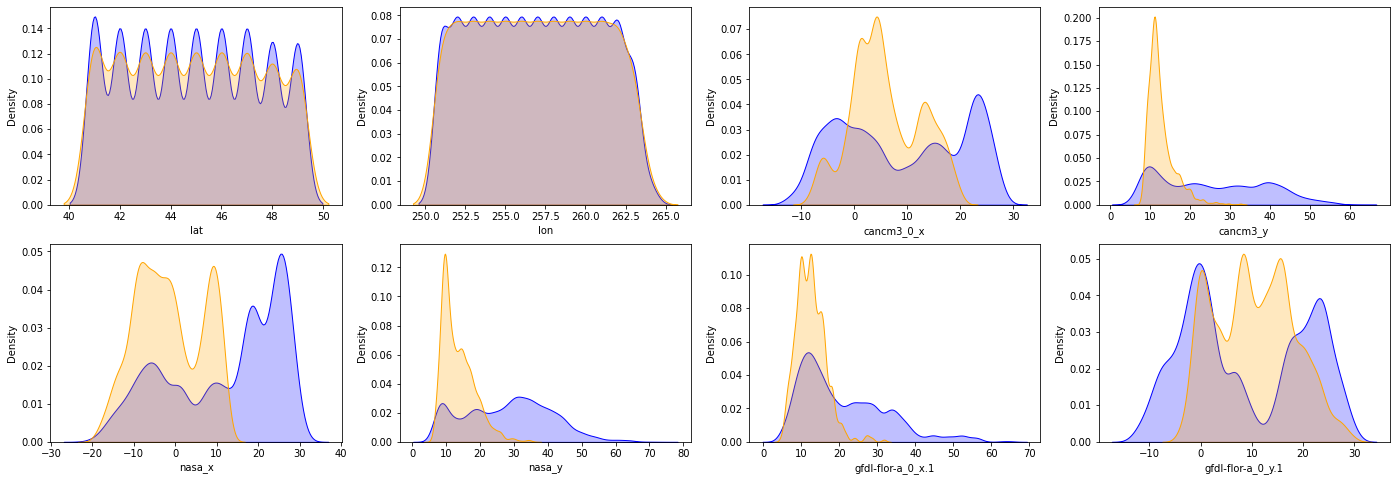

In [ ]:
import math

def show_feature_distributions(features_list):
  width = 4
  height = math.ceil(len(features_list)/width)
  fig, axs = plt.subplots(height, width, figsize=(6*width, 4*height))
  for i, feature in enumerate(features_list):
    ax = axs.flat[i]
    feature = features_list[i]
    sns.kdeplot(data=x_train[feature],  color='blue', fill=True, ax=ax)
    sns.kdeplot(data=x_test[feature], color='orange', fill=True, ax=ax)
  plt.show()


features_list = ['lat', 'lon', 'cancm3_0_x', 'cancm3_y', 'nasa_x', 'nasa_y', 'gfdl-flor-a_0_x.1', 'gfdl-flor-a_0_y.1'	]

show_feature_distributions(features_list)


The feature distribution plots show that many of our features have drifted between the train and test data sets.  The exceptions are the 'lat' and 'lon' features.  This makes sense because these features reference location, which we would not expect to change over time in this data set.  

The distributional changes we have shown here are called **Univariate drift** , meaning that the distributions of individual features have changed over time. 

Data drift is a difficult problem to avoid without regularly retraining your model. One way to reduce the frequency of retraining is to create more of a robust model that can generalize well to new data.  This may require some more sophisticated feature engineering work.

#Feature Engineering

Another way to begin to handle this data drift is to encode aspects of our dropped date columns into new features that we build- a process called feature engineering. Here, we convert our date information to give use the *day of the year, month, and season*.

In [ ]:
def build_date_features(df, ref_set, date_key='start_date'):
  df[date_key] = pd.to_datetime(ref_set[date_key])
  df['day_of_year'] = df[date_key].dt.day_of_year
  df['month'] = df[date_key].dt.month
  df = df.drop([date_key], axis=1) 

build_date_features(x_train, train_split)
build_date_features(x_test, test_split)

In [ ]:
def add_season(df):
  month_to_season = {
      1: 0,
      2: 0,
      3: 1,
      4: 1,
      5: 1,
      6: 2,
      7: 2,
      8: 2, 
      9: 3, 
      10: 3,
      11: 3,
      12: 0
  }
  df['season'] = df['month'].apply(lambda x: month_to_season[x])

add_season(x_train)
add_season(x_test)

We also take advantage of cyclical feature encoding- sine and cosine encoding this variable to take advantage of the cyclical nature of a year's time period. 

In [ ]:
## https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html

from sklearn.preprocessing import FunctionTransformer

def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

In [ ]:
def encode_cyclical(df):
  # encode the day with a period of 365
  df['day_of_year_sin'] = sin_transformer(365).fit_transform(df['day_of_year'])
  df['day_of_year_cos'] = cos_transformer(365).fit_transform(df['day_of_year'])

  # encode the month with a period of 12
  df['month_sin'] = sin_transformer(12).fit_transform(df['month'])
  df['month_cos'] = cos_transformer(12).fit_transform(df['month'])

  # encode the season with a period of 4
  df['season_sin'] = sin_transformer(4).fit_transform(df['season'])
  df['season_cos'] = cos_transformer(4).fit_transform(df['season'])

encode_cyclical(x_train)
encode_cyclical(x_test)

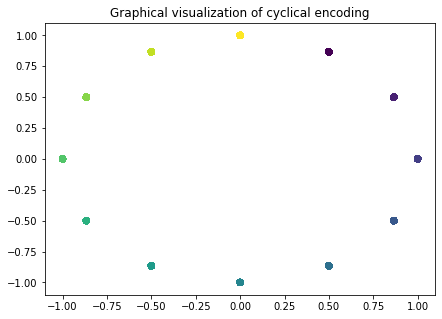

In [ ]:
all_data = pd.concat([x_train, x_test])
fig, ax = plt.subplots(figsize=(7, 5))
plt.title("Graphical visualization of cyclical encoding")
ax.scatter(all_data["month_sin"], all_data["month_cos"], c=all_data["month"])


# Feature Selection 

We are going to look at two key techniques for selecting important features for the model. The first is correlation and second is feature importance. 

### Correlation 

It is typically recommended to remove highly correlated variables when building out ML models. This is not only because there are specific model architectures that perform poorly under multicollinearity, but also because highly correlated variables have been shown to introduce higher risk of errrors. This is because having many correlated variables increases the complexity of your model without introducing a lot of additional, new information. 

In [ ]:
print(len(x_train.columns))

94


One of the most common ways for people to check for correlation features is to visualize your feature space with a heatmap. However, with this many features we can see that a heatmap can be a bit overwhelming. 

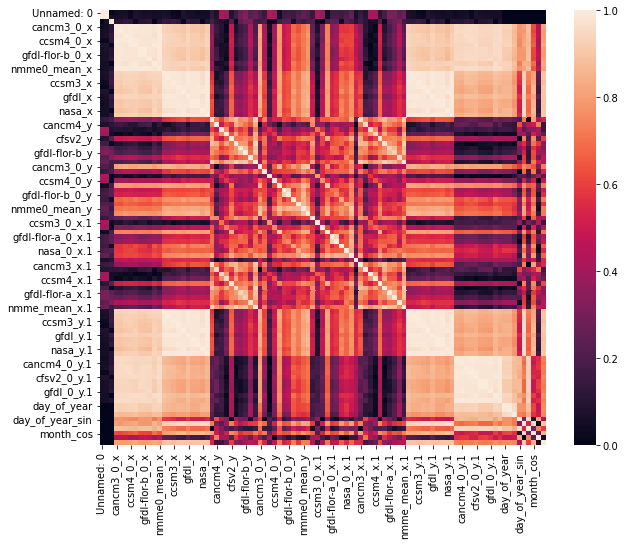

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns 
matrix = x_train.corr().abs()

plt.figure(figsize=(10,8))
_ = sns.heatmap(matrix)

From this heatmap, we can see there are large sections of highly correlated features. However, it may be difficult to remove highly correlated features visually. So instead, we are going to use a common method to identify highly correlated features and remove them from our dataset. 

This method utilizes the correlation matrix that we saw in the heatmap above. We can see in that plot that the heatmap is actually symmetrical across the diagonal. So, we are able to actually mask the correlation matrix on upper triangle and use our reduced correlation matrix to find correlations that are too high, as determined by our designated threshold. 

In [ ]:
## Identify correlated features to drop that fall above a correlation threshold 
## https://goodboychan.github.io/python/datacamp/machine_learning/2020/07/08/02-Feature-selection-I-selecting-for-feature-information.html 

def identify_correlated(df, threshold):
    corr_matrix = df.corr().abs()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    reduced_corr_matrix = corr_matrix.mask(mask)
    features_to_drop = [c for c in reduced_corr_matrix.columns if any(reduced_corr_matrix[c] > threshold)]
    return features_to_drop

In [ ]:
# separate tmp2m, the target variable from the features
x_train = train_split.drop(['tmp2m', 'start_date'], axis=1) 
y_train = train_split['tmp2m']
x_test = test_split.drop(['tmp2m', 'start_date'], axis=1).reset_index(drop=True)
y_test = test_split['tmp2m'].reset_index(drop=True)

In [ ]:
print(len(x_train.columns))

84


In [ ]:
## Get the column names to drop 
to_drop = identify_correlated(x_train, threshold=.96)

In [ ]:
x_train_reduced = pd.DataFrame(x_train.drop(to_drop, axis=1))

In [ ]:
print(len(x_train_reduced.columns))

41


As we can see, we dropped 45 highly correlated features from our training dataset. 

In [ ]:
x_test_reduced = pd.DataFrame(x_test.drop(to_drop, axis=1))
print(len(x_test_reduced.columns))

41


In [ ]:
pipeline = Pipeline(steps = [
              ('scaler', StandardScaler())
              ,('regressor',RandomForestRegressor())
           ])

rf_model2 = pipeline.fit(x_train_reduced, y_train)

train_preds = rf_model2.predict(x_train_reduced)
train_score = r2_score(y_train, train_preds)

test_preds = rf_model2.predict(x_test_reduced)
test_score = r2_score(y_test, test_preds)

print (f'Training Performance: {train_score}')
print (f'Test Performance: {test_score}')

Training Performance: 0.9993036110802138
Test Performance: 0.7175495406702349


Here we can see an improved training performance than what we ran above. 

## Feature Importance 

Another common feature selection technique can be done utilizing feature importance. It works in a very similar way to correlation searching for features that are adding more noise than additional information. As we saw before, when using correlation to search for noise, we are searching for noise that is brought on by having many variables giving the same information. 

However, when we choose to use Feature Importance, we are not actually comparing the features to each other. Instead, we are looking at each of the features independently and evaluating how useful each feature is to solving the actual problem. It does this by evaluating how important each feature is to driving the prediction the model makes. We can use these importance scores in feature selection to remove any features that do little to drive model predictions and instead only add noise to our models. 

### Feature Importance Technique : Random Forest Regressor

We are first going to look at feature importance using one of the most common techniques (which is incidentally one that we have been using) - the Random Forest Regressor. Random Forest models are able to generate feature importance scores by calculating node impurity and probability of reaching that node at each of the model's decision points. Many teams will utilize random forest models to evaluate feature importane for feature selection, even if they are going to use a more advanced architecture for their actual modeling. 

In [ ]:
importances = rf_model2.steps[1][1].feature_importances_

<BarContainer object of 41 artists>

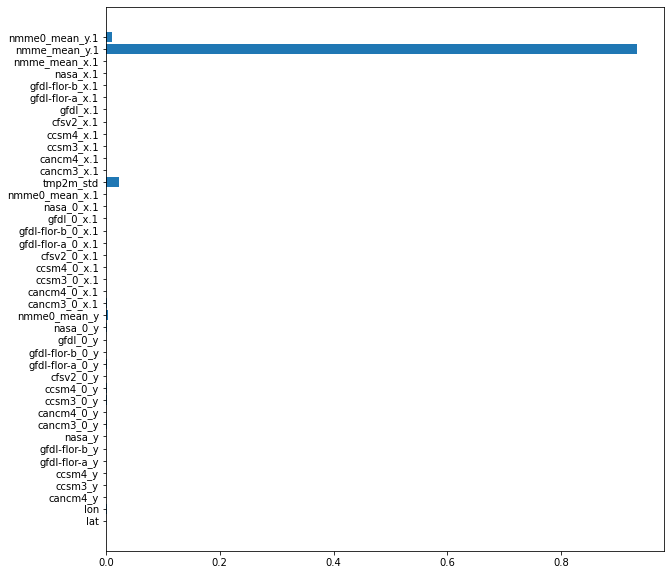

In [ ]:
plt.figure(figsize=(10,10))
plt.barh(x_train_reduced.columns, importances, height = .8)


We can see that there are very few important features. Based on this plot, we think that it would be interesting to see if pruning our model for a small number of the most important features would lead to improvements in our model. To do this, we can use the common Recursive Feature Extraction using Cross Validation. 

### Recursive Feature Extraction using Cross Validation 

RFECV works to prune features from the model utilizing feature importance scores. Every step it removes the least important features (number of features removed is determined by the step) and evaluates whether or not that provided an increase in accuracy for the model. An important difference between this technique and typical recursive feature extraction is that this technique uses cross validation. In the example below, we specify 3 meaning that a 3 fold cross validation occurs with each evaluation to help validate that the removal of features was not justified just by the sample taken. 

A great resouce for machine learning content is the machine learning mastery blog. Here are two additional resources on both feature extraction and K-Fold cross validation. 
* More information about Feature Extraction: https://machinelearningmastery.com/rfe-feature-selection-in-python/#:~:text=Technically%2C%20RFE%20is%20a%20wrapper,until%20the%20desired%20number%20remains. 
* More information about K Fold Cross Validation: https://machinelearningmastery.com/k-fold-cross-validation/ 

In [ ]:
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html

from sklearn.feature_selection import RFECV
estimator = RandomForestRegressor()
selector = RFECV(estimator, step=8, cv=3)
selector = selector.fit(x_train_reduced, y_train)

We can use this to find the features that our recursive technique considers to be important. We can see the features ranked below:

In [ ]:
print("Feature ranking: ", selector.ranking_)

Feature ranking:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 2 2 1 2 1 2 2 1 1 1 1 1 2 1 1 1
 1 2 1 1]


In [ ]:
## Get features marked as important (or to keep) by RFECV

mask = selector.get_support()
mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True, False, False,  True, False,  True, False,
       False,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True, False,  True,  True])

In [ ]:
features = np.array(x_train_reduced.columns)
best_features = features[mask]

In [ ]:
best_features

array(['lat', 'lon', 'cancm4_y', 'ccsm3_y', 'ccsm4_y', 'gfdl-flor-a_y',
       'gfdl-flor-b_y', 'nasa_y', 'cancm3_0_y', 'cancm4_0_y', 'ccsm3_0_y',
       'ccsm4_0_y', 'cfsv2_0_y', 'gfdl-flor-a_0_y', 'gfdl_0_y',
       'nasa_0_y', 'nmme0_mean_y', 'cancm3_0_x.1', 'cancm4_0_x.1',
       'ccsm3_0_x.1', 'gfdl-flor-a_0_x.1', 'gfdl_0_x.1', 'tmp2m_std',
       'cancm3_x.1', 'cancm4_x.1', 'ccsm3_x.1', 'ccsm4_x.1', 'gfdl_x.1',
       'gfdl-flor-a_x.1', 'gfdl-flor-b_x.1', 'nasa_x.1', 'nmme_mean_y.1',
       'nmme0_mean_y.1'], dtype=object)

In [ ]:
x_train_reduced_import_ft = x_train_reduced[best_features]
x_test_reduced_import_ft = x_test_reduced[best_features]


pipeline = Pipeline(steps = [
              ('scaler', StandardScaler())
              ,('regressor',RandomForestRegressor())
           ])

rf_model2 = pipeline.fit(x_train_reduced_import_ft, y_train)

train_preds = rf_model2.predict(x_train_reduced_import_ft)
train_score = r2_score(y_train, train_preds)

test_preds = rf_model2.predict(x_test_reduced_import_ft)
test_score = r2_score(y_test, test_preds)

print (f'Training Performance: {train_score}')
print (f'Test Performance: {test_score}')

Training Performance: 0.9992928463323676
Test Performance: 0.7208997117668368


With this we can see continues improvement in our model. 